In [1]:
from brian2 import *
from brian2modelfitting import *
import pandas as pd
import numpy as np
from torch import nn
import torch
import numpy as np

In [2]:
# data generated from the simulator as defined in:
# https://github.com/brian-team/brian2/blob/master/examples/advanced/modelfitting_sbi.py#L33-L91
inp_traces = np.load('../data/input_traces_sim.npy').reshape(1, -1)
out_traces = np.load('../data/output_traces_sim.npy')

In [3]:
# Time domain
dt = 0.05*ms
t = arange(0, out_traces.size*dt/ms, dt/ms)

In [4]:
gleak = 10*nS
Eleak = -70*mV
VT = -60.0*mV
C = 200*pF
ENa = 53*mV
EK = -107*mV

eqs = '''
     dVm/dt = -(gNa*m**3*h*(Vm - ENa) + gK*n**4*(Vm - EK) + gleak*(Vm - Eleak) - I_inj) / C : volt
     dm/dt = alpham*(1-m) - betam*m : 1
     dn/dt = alphan*(1-n) - betan*n : 1
     dh/dt = alphah*(1-h) - betah*h : 1

     alpham = (-0.32/mV) * (Vm - VT - 13.*mV) / (exp((-(Vm - VT - 13.*mV))/(4.*mV)) - 1)/ms : Hz
     betam = (0.28/mV) * (Vm - VT - 40.*mV) / (exp((Vm - VT - 40.*mV)/(5.*mV)) - 1)/ms : Hz

     alphah = 0.128 * exp(-(Vm - VT - 17.*mV) / (18.*mV))/ms : Hz
     betah = 4/(1 + exp((-(Vm - VT - 40.*mV)) / (5.*mV)))/ms : Hz

     alphan = (-0.032/mV) * (Vm - VT - 15.*mV) / (exp((-(Vm - VT - 15.*mV)) / (5.*mV)) - 1)/ms : Hz
     betan = 0.5*exp(-(Vm - VT - 10.*mV) / (40.*mV))/ms : Hz
     # The parameters to fit
     gNa : siemens (constant)
     gK : siemens (constant)
     '''

In [5]:
# Simulation-based inference object instantiation
inferencer = Inferencer(dt=dt, model=eqs,
                        input={'I_inj': inp_traces*amp},
                        output={'Vm': out_traces*mV},
                        method='exponential_euler',
                        threshold='m>0.5', refractory='m>0.5',
                        param_init={'Vm': 'Eleak',
                                    'm': '1/(1 + betam/alpham)',
                                    'h': '1/(1 + betah/alphah)',
                                    'n': '1/(1 + betan/alphan)'})

In [8]:
# Generate prior and train the neural density estimator
p = inferencer.infere(n_samples=10000,
                      n_rounds=1,
                      inference_method='SNPE',
                      density_estimator_model='mdn',
                      gNa=[.5*uS, 80.*uS],
                      gK=[1e-4*uS, 15.*uS])

Round 1/1.
Neural network successfully converged after 25 epochs.


In [13]:
# Draw samples from posterior
s = inferencer.sample((10000, ))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
list(inferencer.param_names)

['gNa', 'gK']

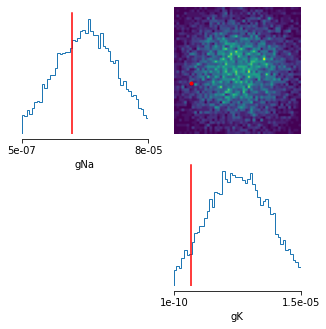

In [31]:
fig, ax = inferencer.pairplot(figsize=(5, 5),
                              limits=[[.5e-6, 80e-6], [1e-10, 15e-6]],
                              ticks=[[.5e-6, 80e-6], [1e-10, 15e-6]],
                              points=np.array([32e-6, 2e-6]),
                              labels=list(inferencer.param_names),
                              points_offdiag={'markersize': 6},
                              points_colors=['r']);